In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
%cd /content/drive/MyDrive/Universidad/Aprendizaje Automático II/Práctica/Trabajos/FINAL/IMAGENES

/content/drive/MyDrive/Universidad/Aprendizaje Automático II/Práctica/Trabajos/FINAL/IMAGENES


In [12]:
import torch  # Asegúrate de importar torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Definir transformaciones para los datos de entrenamiento y validación
transformaciones = transforms.Compose([
    transforms.Resize((100, 100)),  # Redimensionar las imágenes
    transforms.ToTensor(),          # Convertir las imágenes a tensores
    
])

# Cargar los datos de entrenamiento y validación
dataset_entrenamiento = ImageFolder(root='/Users/alejandroalemanaleman/Downloads/AA2 - trabajo 1/train', transform=transformaciones)
dataset_validacion = ImageFolder(root='/Users/alejandroalemanaleman/Downloads/AA2 - trabajo 1/validation', transform=transformaciones)
dataset_test = ImageFolder(root='/Users/alejandroalemanaleman/Downloads/AA2 - trabajo 1/test', transform=transformaciones)

In [13]:
import copy

class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.best_model_wts = None

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.best_model_wts = copy.deepcopy(model.state_dict())

        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

        else:
            self.best_score = score
            self.best_model_wts = copy.deepcopy(model.state_dict())
            self.counter = 0

In [14]:
import torch.nn as nn
import torch.nn.functional as F

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()

        # Capas convolucionales con ajustes en kernel_size y padding
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)  # kernel_size reducido a 3
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)  # kernel_size reducido a 3
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)  # Última capa convolucional

        # Batch Normalization para cada capa convolucional
        self.bn1 = nn.BatchNorm2d(num_features=32)
        self.bn2 = nn.BatchNorm2d(num_features=64)
        self.bn3 = nn.BatchNorm2d(num_features=128)

        # MaxPooling y Dropout
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)  # Reduce el tamaño a la mitad
        self.dropout_conv = nn.Dropout(p=0.25)  # Dropout para capas convolucionales
        self.dropout_fc = nn.Dropout(p=0.5)  # Dropout para capas densas

        # Capas completamente conectadas (ajustar dimensiones según salida final de convoluciones)
        self.fc1 = nn.Linear(128 * 12 * 12, 256)  # Ajuste a tamaño final después de 3 capas convolucionales
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 7)  # Salida para 7 clases

        # Batch Normalization para capas densas
        self.fc_bn1 = nn.BatchNorm1d(256)
        self.fc_bn2 = nn.BatchNorm1d(128)

    def forward(self, x):
        # Pasos convolucionales con activación, normalización y pooling
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.dropout_conv(x)

        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.dropout_conv(x)

        x = self.pool(F.relu(self.bn3(self.conv3(x))))  # Última capa convolucional
        x = self.dropout_conv(x)

        # Aplanar para pasar a capas densas
        x = x.view(-1, 128 * 12 * 12)  # Dimensión ajustada según la salida convolucional

        # Pasos densos con activación, normalización y dropout
        x = F.relu(self.fc_bn1(self.fc1(x)))
        x = self.dropout_fc(x)

        x = F.relu(self.fc_bn2(self.fc2(x)))
        x = self.dropout_fc(x)

        x = self.fc3(x)  # Sin activación final porque CrossEntropyLoss la incluye
        return x



In [16]:
def graficar_perdida_entrenamiento_validacion(lr, batch_size, epochs, valores_perdida, exactitud_entrenamiento, exactitud_validacion):
    # Crear una figura con dos subgráficos en una fila
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    # Graficar la función de pérdida en el primer subgráfico
    ax[0].plot(valores_perdida, label='Pérdida')
    ax[0].set_xlabel('Épocas')
    ax[0].set_ylabel('Pérdida')
    ax[0].set_title(f'Función de Pérdida\n LR: {lr} Batch Size: {batch_size}')
    ax[0].legend()

    # Graficar las exactitudes en el segundo subgráfico
    ax[1].plot(exactitud_entrenamiento, label='Exactitud de Entrenamiento')
    ax[1].plot(exactitud_validacion, label='Exactitud de Validación')
    ax[1].set_xlabel('Épocas')
    ax[1].set_ylabel('Exactitud')
    ax[1].set_title(f'Exactitud de Entrenamiento y Validación\n LR: {lr} Batch Size: {batch_size}')
    ax[1].legend()

    # Ajustar espaciado entre los gráficos
    plt.tight_layout()

    # Mostrar los gráficos
    plt.show()

In [17]:
def calcular_exactitud_test(modelo, dataloader_test, device):
    correctas = 0
    total = 0
    with torch.no_grad():
        modelo.eval()

        for images, labels in dataloader_test:
            images, labels = images.to(device), labels.to(device)
            outputs = modelo(images)
            _, predicted = torch.max(outputs.data,1)
            total += labels.size(0)
            correctas += (predicted == labels).sum().item()
        #print(f'Exactitud de el modelo con las {total} imágenes de test: {100*correctas/total}%')
    return 100*correctas/total

In [18]:
def matriz_de_confusion(modelo, dataloader_test, device):

    modelo.eval()

    # Inicializar listas para etiquetas reales y predicciones
    predicciones_totales = []
    etiquetas_reales_totales = []

    # Verificar que el dataloader_test tiene datos
    if len(dataloader_test.dataset) == 0:
        print("El conjunto de test está vacío. Verifica los datos.")
    else:
        # Bucle para obtener predicciones
        with torch.no_grad():
            for imagenes, etiquetas in dataloader_test:
                imagenes, etiquetas = imagenes.to(device), etiquetas.to(device)
                salidas = modelo(imagenes)
                _, predicciones = torch.max(salidas, 1)
                predicciones_totales.extend(predicciones.cpu().numpy())
                etiquetas_reales_totales.extend(etiquetas.cpu().numpy())

    # Comprobar si se obtuvieron predicciones
    if len(etiquetas_reales_totales) > 0 and len(predicciones_totales) > 0:
        # Imprimir el reporte de clasificación
        print("Reporte de clasificación:")
        print(classification_report(etiquetas_reales_totales, predicciones_totales, digits=4))

        # Crear la matriz de confusión
        etiquetas_unicas = sorted(set(etiquetas_reales_totales))  # Identificar las clases presentes
        matriz_confusion_test = confusion_matrix(etiquetas_reales_totales, predicciones_totales, labels=etiquetas_unicas)

        # Visualizar la matriz de confusión
        plt.figure(figsize=(10, 8))
        sns.heatmap(matriz_confusion_test, annot=True, fmt='d', cmap='Blues', xticklabels=etiquetas_unicas, yticklabels=etiquetas_unicas)
        plt.xlabel('Predicciones')
        plt.ylabel('Etiquetas Reales')
        plt.title('Matriz de Confusión del Conjunto de Test')
        plt.show()

        # Mostrar las clases presentes
        clases_presentes = set(etiquetas_reales_totales)
        print(f"Clases presentes en el conjunto de test: {clases_presentes}")
    else:
        print("No se encontraron datos válidos para generar predicciones o etiquetas.")


Entrenando con lr=0.005, batch_size=32, epochs=15
    Época 1, pérdida: 1.3993, exactitud entrenamiento: 59.83%, exactitud validación: 56.88%
    Época 2, pérdida: 1.0831, exactitud entrenamiento: 74.00%, exactitud validación: 69.72%
    Época 3, pérdida: 0.8532, exactitud entrenamiento: 72.40%, exactitud validación: 66.61%
    Época 4, pérdida: 0.7501, exactitud entrenamiento: 32.78%, exactitud validación: 31.01%
    Época 5, pérdida: 0.6529, exactitud entrenamiento: 64.85%, exactitud validación: 57.61%
    Época 6, pérdida: 0.5674, exactitud entrenamiento: 79.36%, exactitud validación: 70.18%
    Época 7, pérdida: 0.4887, exactitud entrenamiento: 78.47%, exactitud validación: 67.61%
    Época 8, pérdida: 0.4513, exactitud entrenamiento: 91.31%, exactitud validación: 78.62%
    Época 9, pérdida: 0.3754, exactitud entrenamiento: 44.89%, exactitud validación: 39.08%
    Época 10, pérdida: 0.3638, exactitud entrenamiento: 90.57%, exactitud validación: 77.06%
    Época 11, pérdida: 0.322

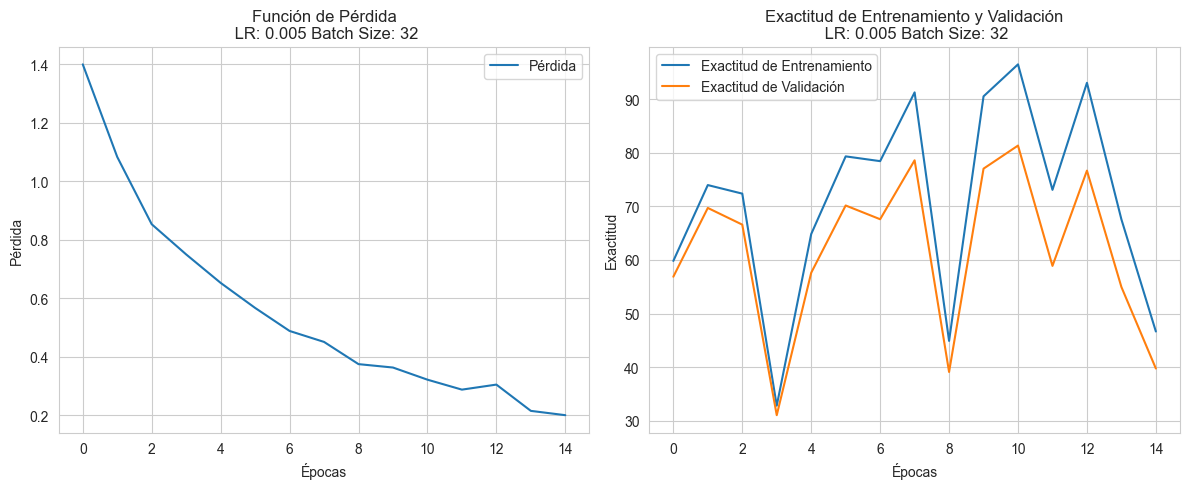


Entrenando con lr=0.005, batch_size=32, epochs=30
    Época 1, pérdida: 1.4200, exactitud entrenamiento: 59.24%, exactitud validación: 56.15%
    Época 2, pérdida: 1.0849, exactitud entrenamiento: 72.80%, exactitud validación: 67.52%
    Época 3, pérdida: 0.8625, exactitud entrenamiento: 76.89%, exactitud validación: 71.56%
    Época 4, pérdida: 0.8053, exactitud entrenamiento: 82.10%, exactitud validación: 75.23%
    Época 5, pérdida: 0.6396, exactitud entrenamiento: 87.37%, exactitud validación: 79.45%
    Época 6, pérdida: 0.5824, exactitud entrenamiento: 78.31%, exactitud validación: 68.07%
    Época 7, pérdida: 0.4780, exactitud entrenamiento: 90.73%, exactitud validación: 78.90%
    Época 8, pérdida: 0.4084, exactitud entrenamiento: 92.76%, exactitud validación: 79.63%
    Época 9, pérdida: 0.4126, exactitud entrenamiento: 91.19%, exactitud validación: 79.45%
    Época 10, pérdida: 0.3803, exactitud entrenamiento: 85.67%, exactitud validación: 70.73%
    Época 11, pérdida: 0.328

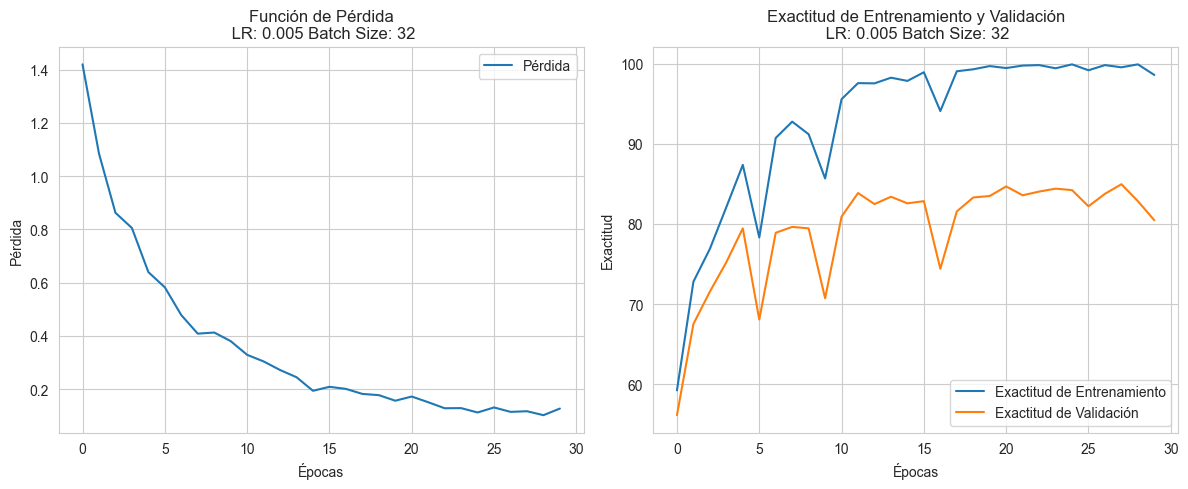


Entrenando con lr=0.005, batch_size=64, epochs=15
    Época 1, pérdida: 1.3971, exactitud entrenamiento: 58.35%, exactitud validación: 55.96%
    Época 2, pérdida: 0.9953, exactitud entrenamiento: 69.78%, exactitud validación: 64.22%
    Época 3, pérdida: 0.8039, exactitud entrenamiento: 72.83%, exactitud validación: 68.44%
    Época 4, pérdida: 0.6604, exactitud entrenamiento: 67.68%, exactitud validación: 60.28%
    Época 5, pérdida: 0.5736, exactitud entrenamiento: 57.36%, exactitud validación: 51.19%
    Época 6, pérdida: 0.5036, exactitud entrenamiento: 75.75%, exactitud validación: 68.53%
    Época 7, pérdida: 0.4228, exactitud entrenamiento: 90.67%, exactitud validación: 77.61%
    Época 8, pérdida: 0.3841, exactitud entrenamiento: 91.53%, exactitud validación: 76.88%
    Época 9, pérdida: 0.3131, exactitud entrenamiento: 91.07%, exactitud validación: 76.06%
    Época 10, pérdida: 0.3102, exactitud entrenamiento: 90.26%, exactitud validación: 77.25%
    Época 11, pérdida: 0.257

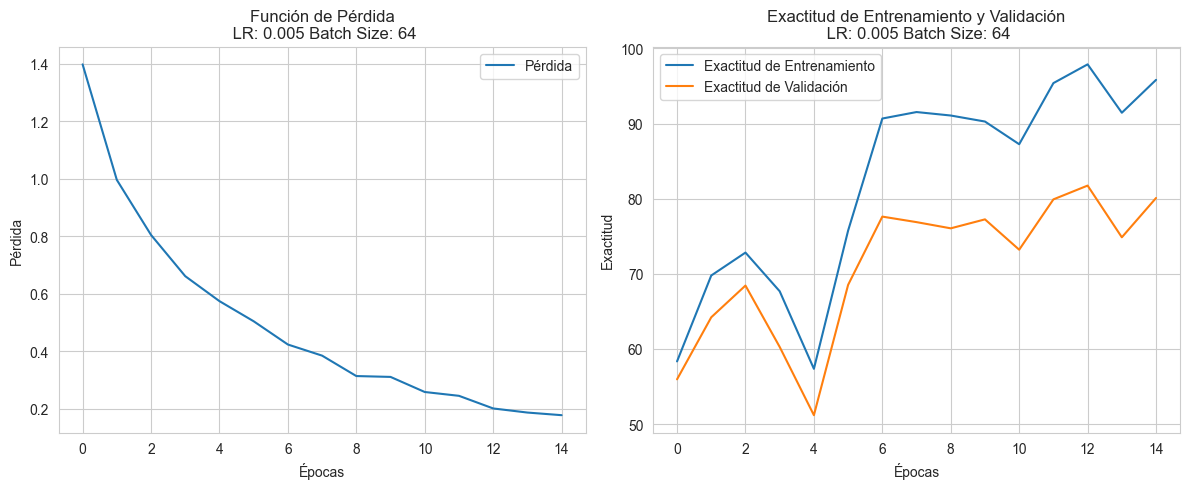


Entrenando con lr=0.005, batch_size=64, epochs=30
    Época 1, pérdida: 1.3698, exactitud entrenamiento: 60.69%, exactitud validación: 58.90%
    Época 2, pérdida: 1.0102, exactitud entrenamiento: 62.26%, exactitud validación: 59.27%
    Época 3, pérdida: 0.8283, exactitud entrenamiento: 79.36%, exactitud validación: 72.66%
    Época 4, pérdida: 0.6917, exactitud entrenamiento: 68.52%, exactitud validación: 62.39%
    Época 5, pérdida: 0.5565, exactitud entrenamiento: 71.23%, exactitud validación: 63.85%
    Época 6, pérdida: 0.5212, exactitud entrenamiento: 87.22%, exactitud validación: 76.88%
    Época 7, pérdida: 0.4476, exactitud entrenamiento: 46.55%, exactitud validación: 41.83%
    Época 8, pérdida: 0.3583, exactitud entrenamiento: 86.29%, exactitud validación: 73.76%
    Época 9, pérdida: 0.3300, exactitud entrenamiento: 94.92%, exactitud validación: 81.47%
    Época 10, pérdida: 0.2952, exactitud entrenamiento: 83.70%, exactitud validación: 70.37%
    Época 11, pérdida: 0.273

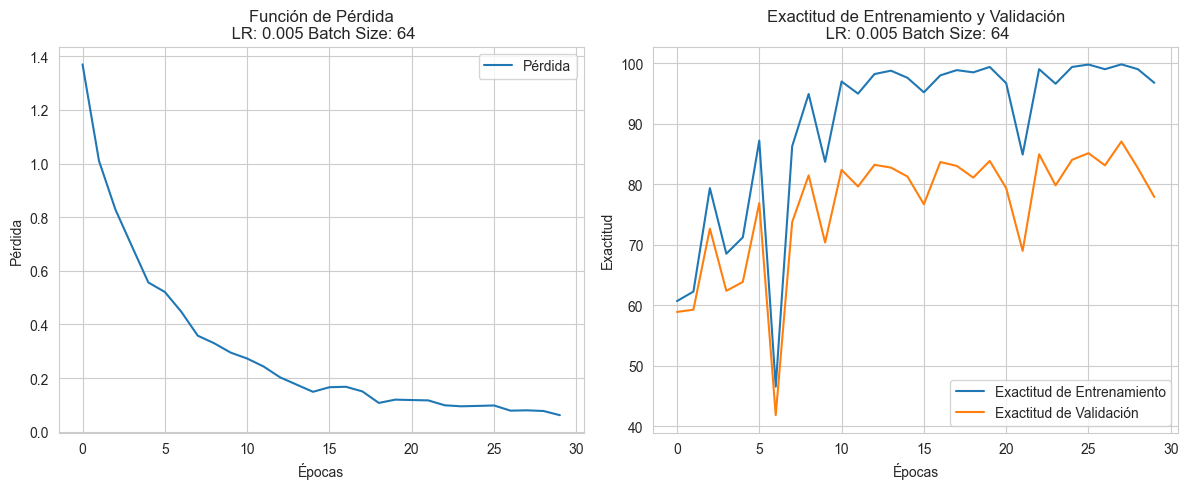


Entrenando con lr=0.001, batch_size=32, epochs=15
    Época 1, pérdida: 1.4054, exactitud entrenamiento: 60.01%, exactitud validación: 56.33%
    Época 2, pérdida: 1.0092, exactitud entrenamiento: 71.60%, exactitud validación: 68.81%
    Época 3, pérdida: 0.7957, exactitud entrenamiento: 77.79%, exactitud validación: 69.17%
    Época 4, pérdida: 0.6693, exactitud entrenamiento: 84.38%, exactitud validación: 75.41%
    Época 5, pérdida: 0.5523, exactitud entrenamiento: 89.65%, exactitud validación: 78.90%
    Época 6, pérdida: 0.4814, exactitud entrenamiento: 81.05%, exactitud validación: 69.82%
    Época 7, pérdida: 0.4348, exactitud entrenamiento: 92.05%, exactitud validación: 80.83%
    Época 8, pérdida: 0.3591, exactitud entrenamiento: 89.34%, exactitud validación: 76.06%
    Época 9, pérdida: 0.3498, exactitud entrenamiento: 92.11%, exactitud validación: 78.62%
    Época 10, pérdida: 0.3221, exactitud entrenamiento: 87.65%, exactitud validación: 73.39%
    Época 11, pérdida: 0.251

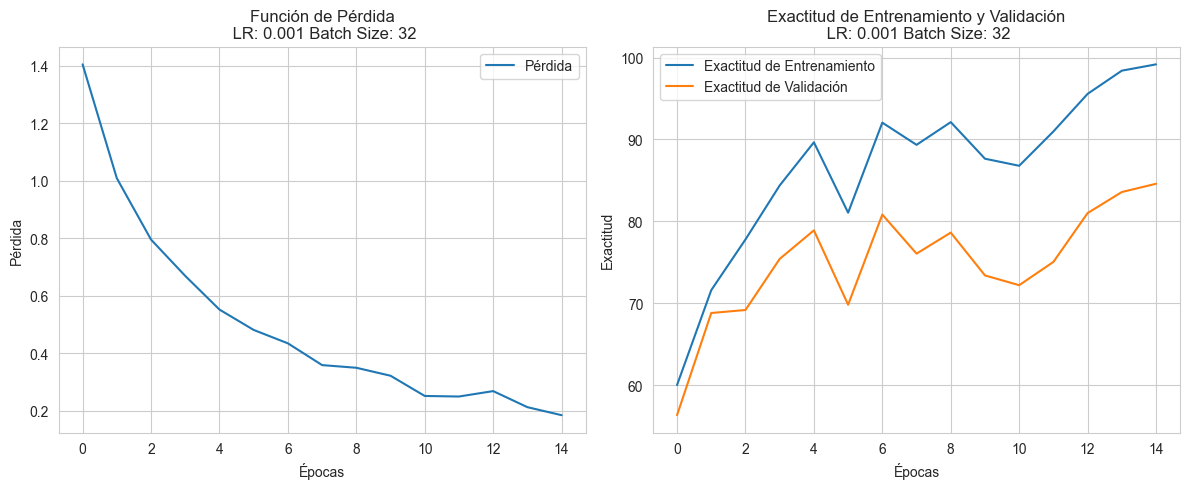


Entrenando con lr=0.001, batch_size=32, epochs=30
    Época 1, pérdida: 1.4364, exactitud entrenamiento: 56.72%, exactitud validación: 53.30%
    Época 2, pérdida: 1.0201, exactitud entrenamiento: 73.35%, exactitud validación: 69.27%
    Época 3, pérdida: 0.8290, exactitud entrenamiento: 72.58%, exactitud validación: 65.60%
    Época 4, pérdida: 0.6995, exactitud entrenamiento: 82.16%, exactitud validación: 74.59%
    Época 5, pérdida: 0.5918, exactitud entrenamiento: 86.35%, exactitud validación: 76.06%
    Época 6, pérdida: 0.5484, exactitud entrenamiento: 62.51%, exactitud validación: 57.71%
    Época 7, pérdida: 0.4359, exactitud entrenamiento: 84.94%, exactitud validación: 74.59%
    Época 8, pérdida: 0.3851, exactitud entrenamiento: 90.11%, exactitud validación: 77.25%
    Época 9, pérdida: 0.3514, exactitud entrenamiento: 96.12%, exactitud validación: 83.03%
    Época 10, pérdida: 0.3113, exactitud entrenamiento: 91.47%, exactitud validación: 77.43%
    Época 11, pérdida: 0.280

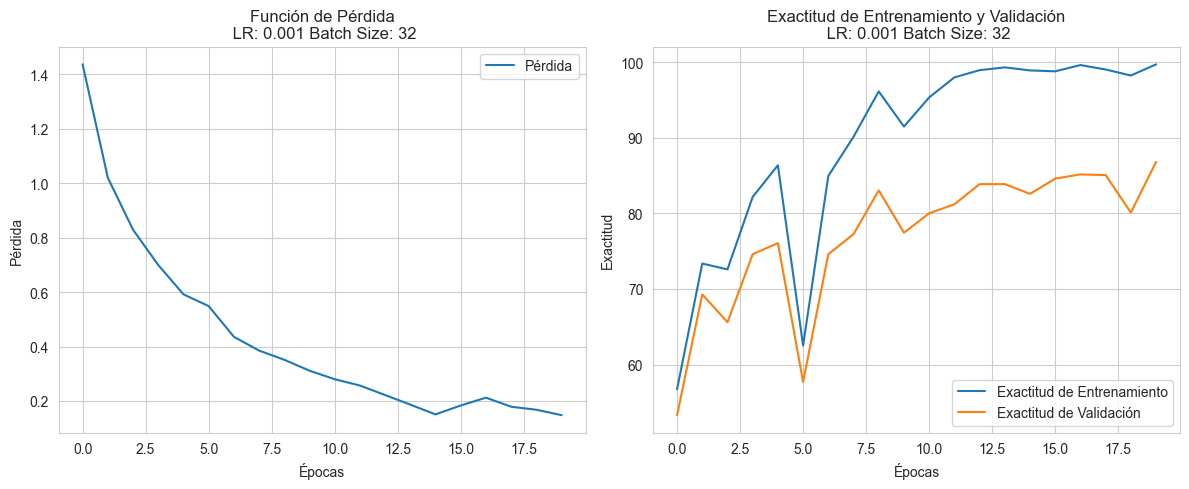


Entrenando con lr=0.001, batch_size=64, epochs=15
    Época 1, pérdida: 1.4423, exactitud entrenamiento: 32.53%, exactitud validación: 31.38%
    Época 2, pérdida: 0.9893, exactitud entrenamiento: 70.86%, exactitud validación: 65.96%
    Época 3, pérdida: 0.7725, exactitud entrenamiento: 78.62%, exactitud validación: 72.75%
    Época 4, pérdida: 0.6415, exactitud entrenamiento: 75.91%, exactitud validación: 68.99%
    Época 5, pérdida: 0.5462, exactitud entrenamiento: 89.00%, exactitud validación: 79.45%
    Época 6, pérdida: 0.4719, exactitud entrenamiento: 89.25%, exactitud validación: 78.07%
    Época 7, pérdida: 0.3996, exactitud entrenamiento: 84.44%, exactitud validación: 73.30%
    Época 8, pérdida: 0.3376, exactitud entrenamiento: 94.39%, exactitud validación: 80.37%
    Época 9, pérdida: 0.3053, exactitud entrenamiento: 92.82%, exactitud validación: 76.88%
    Época 10, pérdida: 0.2831, exactitud entrenamiento: 93.07%, exactitud validación: 78.26%
    Época 11, pérdida: 0.229

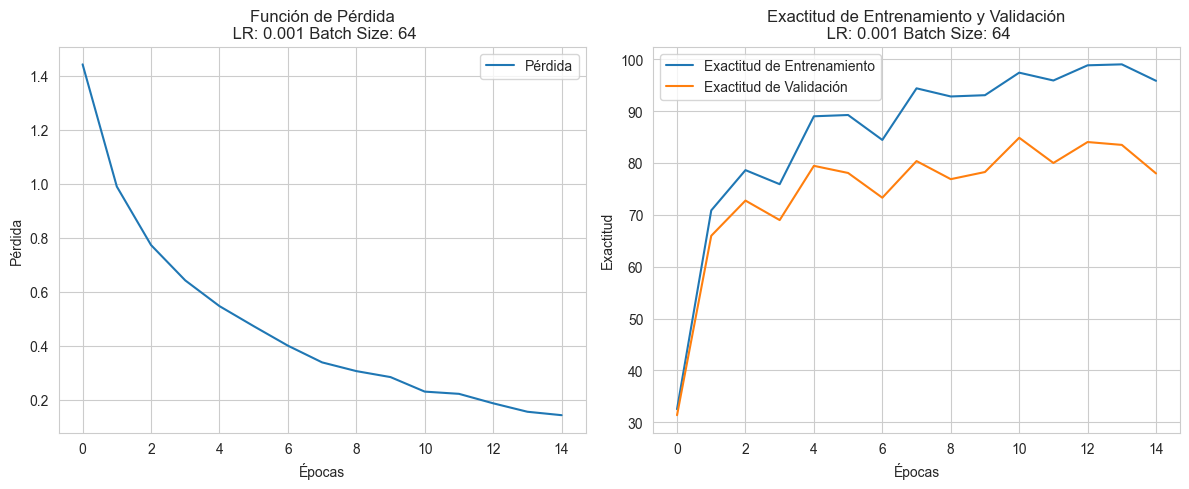


Entrenando con lr=0.001, batch_size=64, epochs=30
    Época 1, pérdida: 1.4224, exactitud entrenamiento: 26.59%, exactitud validación: 26.70%
    Época 2, pérdida: 1.0013, exactitud entrenamiento: 61.00%, exactitud validación: 56.15%
    Época 3, pérdida: 0.8001, exactitud entrenamiento: 76.40%, exactitud validación: 68.99%
    Época 4, pérdida: 0.6525, exactitud entrenamiento: 84.41%, exactitud validación: 77.16%
    Época 5, pérdida: 0.5626, exactitud entrenamiento: 63.37%, exactitud validación: 58.72%
    Época 6, pérdida: 0.4890, exactitud entrenamiento: 85.09%, exactitud validación: 75.96%
    Época 7, pérdida: 0.3904, exactitud entrenamiento: 69.07%, exactitud validación: 59.17%
    Época 8, pérdida: 0.3843, exactitud entrenamiento: 94.76%, exactitud validación: 81.01%
    Época 9, pérdida: 0.3408, exactitud entrenamiento: 96.80%, exactitud validación: 81.28%
    Época 10, pérdida: 0.2685, exactitud entrenamiento: 97.29%, exactitud validación: 83.30%
    Época 11, pérdida: 0.228

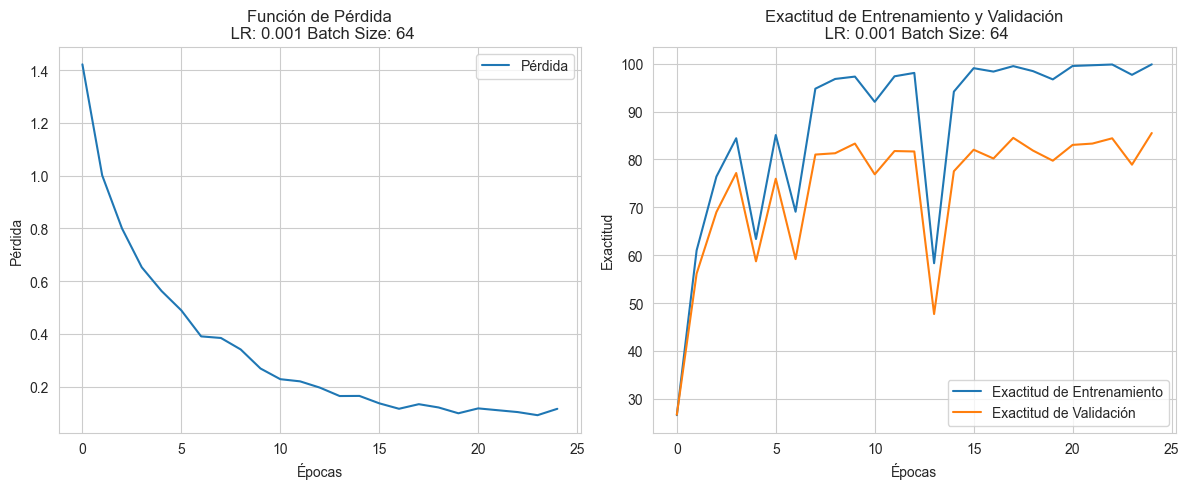


Entrenando con lr=0.0005, batch_size=32, epochs=15
    Época 1, pérdida: 1.4808, exactitud entrenamiento: 39.59%, exactitud validación: 38.26%
    Época 2, pérdida: 1.0678, exactitud entrenamiento: 62.57%, exactitud validación: 59.27%
    Época 3, pérdida: 0.8498, exactitud entrenamiento: 70.43%, exactitud validación: 64.59%
    Época 4, pérdida: 0.7249, exactitud entrenamiento: 78.19%, exactitud validación: 71.28%
    Época 5, pérdida: 0.6255, exactitud entrenamiento: 84.97%, exactitud validación: 76.42%
    Época 6, pérdida: 0.5257, exactitud entrenamiento: 72.55%, exactitud validación: 63.76%
    Época 7, pérdida: 0.4355, exactitud entrenamiento: 91.62%, exactitud validación: 81.74%
    Época 8, pérdida: 0.4177, exactitud entrenamiento: 83.86%, exactitud validación: 70.92%
    Época 9, pérdida: 0.3779, exactitud entrenamiento: 94.79%, exactitud validación: 80.00%
    Época 10, pérdida: 0.3351, exactitud entrenamiento: 97.01%, exactitud validación: 83.30%
    Época 11, pérdida: 0.29

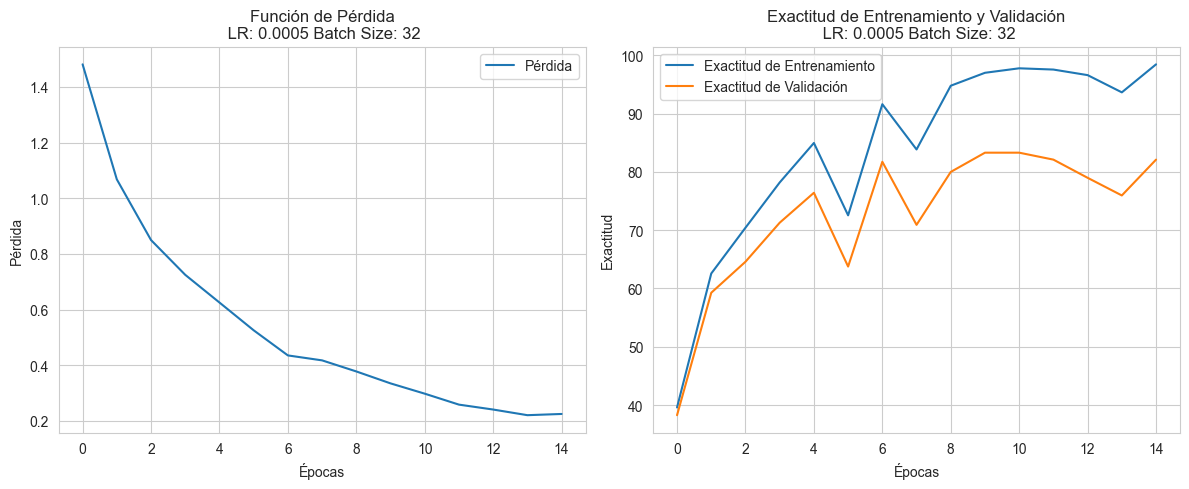


Entrenando con lr=0.0005, batch_size=32, epochs=30
    Época 1, pérdida: 1.4671, exactitud entrenamiento: 53.60%, exactitud validación: 52.48%
    Época 2, pérdida: 1.0749, exactitud entrenamiento: 64.11%, exactitud validación: 60.00%
    Época 3, pérdida: 0.8815, exactitud entrenamiento: 70.09%, exactitud validación: 64.50%
    Época 4, pérdida: 0.7207, exactitud entrenamiento: 84.53%, exactitud validación: 77.34%
    Época 5, pérdida: 0.6428, exactitud entrenamiento: 86.94%, exactitud validación: 78.26%
    Época 6, pérdida: 0.5570, exactitud entrenamiento: 86.51%, exactitud validación: 74.86%
    Época 7, pérdida: 0.4696, exactitud entrenamiento: 87.58%, exactitud validación: 77.34%
    Época 8, pérdida: 0.4269, exactitud entrenamiento: 94.64%, exactitud validación: 81.83%
    Época 9, pérdida: 0.3895, exactitud entrenamiento: 96.89%, exactitud validación: 84.50%
    Época 10, pérdida: 0.3129, exactitud entrenamiento: 92.98%, exactitud validación: 78.35%
    Época 11, pérdida: 0.32

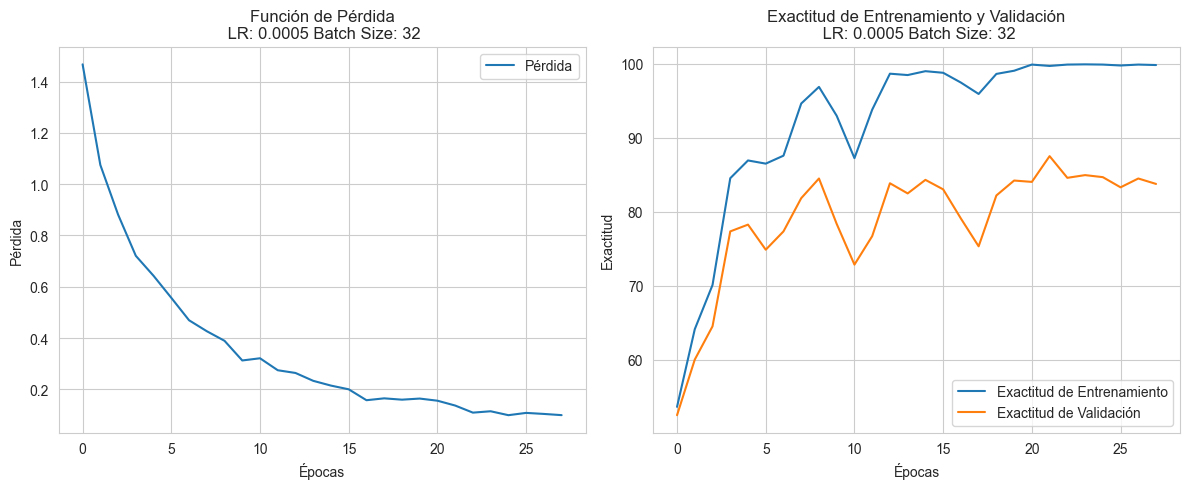


Entrenando con lr=0.0005, batch_size=64, epochs=15
    Época 1, pérdida: 1.5796, exactitud entrenamiento: 25.57%, exactitud validación: 26.70%
    Época 2, pérdida: 1.1279, exactitud entrenamiento: 52.28%, exactitud validación: 50.00%
    Época 3, pérdida: 0.9035, exactitud entrenamiento: 68.64%, exactitud validación: 63.12%
    Época 4, pérdida: 0.7492, exactitud entrenamiento: 73.07%, exactitud validación: 68.62%
    Época 5, pérdida: 0.6635, exactitud entrenamiento: 78.43%, exactitud validación: 72.48%
    Época 6, pérdida: 0.5554, exactitud entrenamiento: 79.76%, exactitud validación: 71.93%
    Época 7, pérdida: 0.5012, exactitud entrenamiento: 90.85%, exactitud validación: 79.45%
    Época 8, pérdida: 0.4574, exactitud entrenamiento: 85.64%, exactitud validación: 72.02%
    Época 9, pérdida: 0.3771, exactitud entrenamiento: 91.74%, exactitud validación: 78.99%
    Época 10, pérdida: 0.3316, exactitud entrenamiento: 89.13%, exactitud validación: 74.86%
    Época 11, pérdida: 0.29

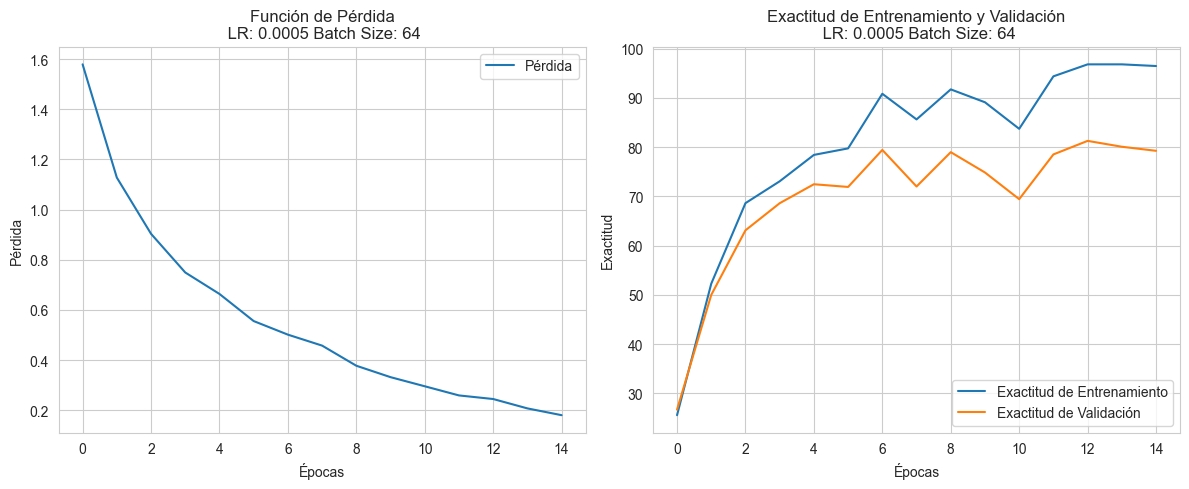


Entrenando con lr=0.0005, batch_size=64, epochs=30
    Época 1, pérdida: 1.4910, exactitud entrenamiento: 19.41%, exactitud validación: 19.72%
    Época 2, pérdida: 1.0974, exactitud entrenamiento: 52.74%, exactitud validación: 49.08%
    Época 3, pérdida: 0.8665, exactitud entrenamiento: 66.11%, exactitud validación: 59.27%
    Época 4, pérdida: 0.7348, exactitud entrenamiento: 69.44%, exactitud validación: 64.59%
    Época 5, pérdida: 0.6135, exactitud entrenamiento: 68.61%, exactitud validación: 61.56%
    Época 6, pérdida: 0.5420, exactitud entrenamiento: 86.35%, exactitud validación: 76.33%
    Época 7, pérdida: 0.4757, exactitud entrenamiento: 87.03%, exactitud validación: 75.05%
    Época 8, pérdida: 0.3973, exactitud entrenamiento: 82.69%, exactitud validación: 70.92%
    Época 9, pérdida: 0.3833, exactitud entrenamiento: 89.68%, exactitud validación: 77.43%
    Época 10, pérdida: 0.3195, exactitud entrenamiento: 95.35%, exactitud validación: 82.11%
    Época 11, pérdida: 0.27

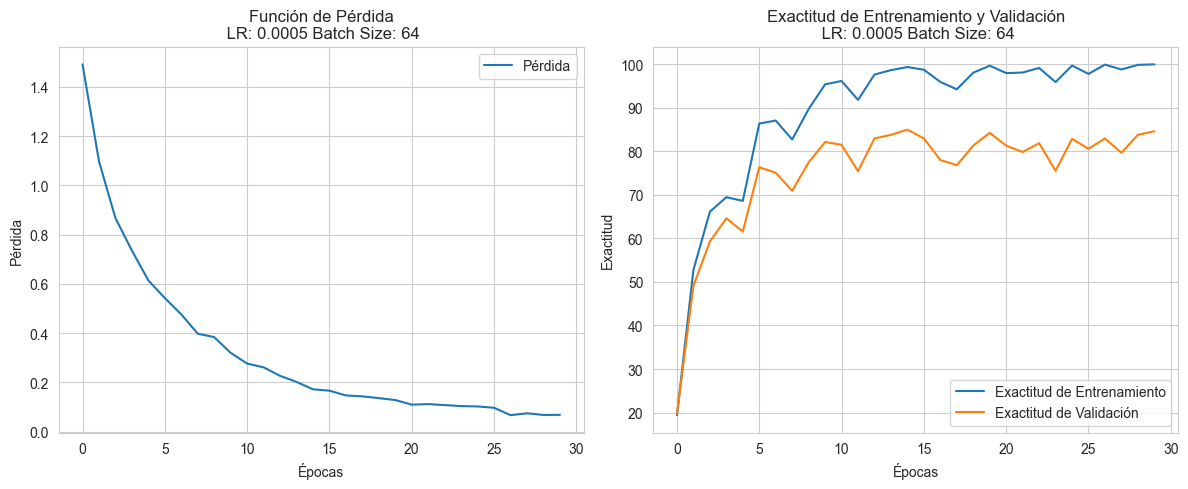


Entrenando con lr=0.0001, batch_size=32, epochs=15
    Época 1, pérdida: 1.6730, exactitud entrenamiento: 22.12%, exactitud validación: 20.28%
    Época 2, pérdida: 1.3556, exactitud entrenamiento: 43.84%, exactitud validación: 42.29%
    Época 3, pérdida: 1.1904, exactitud entrenamiento: 55.21%, exactitud validación: 52.39%
    Época 4, pérdida: 1.0665, exactitud entrenamiento: 54.13%, exactitud validación: 49.27%
    Época 5, pérdida: 0.9503, exactitud entrenamiento: 63.28%, exactitud validación: 58.62%
    Época 6, pérdida: 0.8748, exactitud entrenamiento: 61.83%, exactitud validación: 57.80%
    Época 7, pérdida: 0.8020, exactitud entrenamiento: 66.79%, exactitud validación: 62.48%
    Época 8, pérdida: 0.7372, exactitud entrenamiento: 57.33%, exactitud validación: 51.47%
    Época 9, pérdida: 0.6989, exactitud entrenamiento: 47.75%, exactitud validación: 44.04%
    Época 10, pérdida: 0.6496, exactitud entrenamiento: 67.50%, exactitud validación: 60.37%
    Época 11, pérdida: 0.59

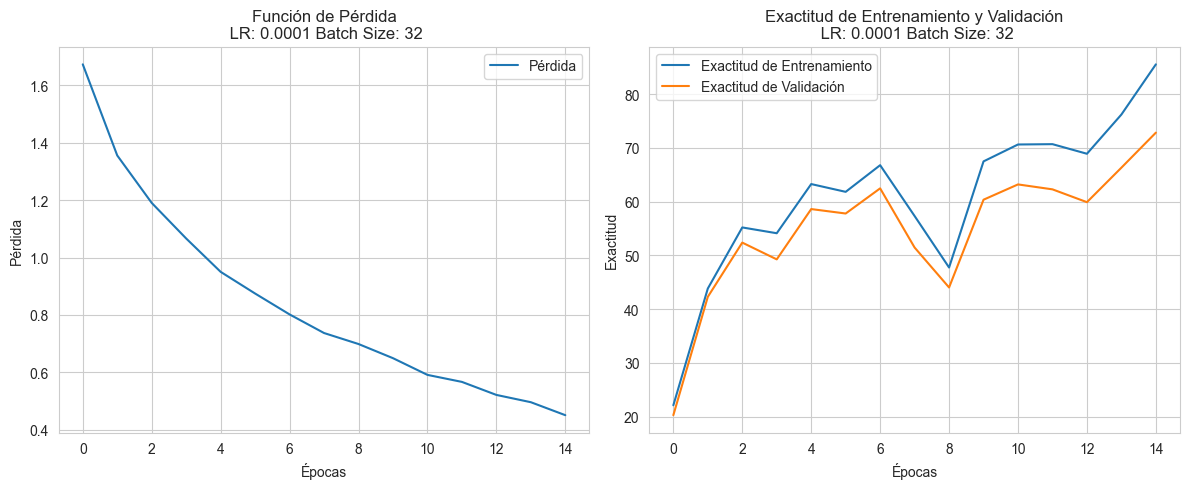


Entrenando con lr=0.0001, batch_size=32, epochs=30
    Época 1, pérdida: 1.6627, exactitud entrenamiento: 38.26%, exactitud validación: 34.95%
    Época 2, pérdida: 1.3580, exactitud entrenamiento: 50.06%, exactitud validación: 46.61%
    Época 3, pérdida: 1.1916, exactitud entrenamiento: 55.05%, exactitud validación: 51.38%
    Época 4, pérdida: 1.0614, exactitud entrenamiento: 60.07%, exactitud validación: 55.50%
    Época 5, pérdida: 0.9788, exactitud entrenamiento: 64.17%, exactitud validación: 60.37%
    Época 6, pérdida: 0.9016, exactitud entrenamiento: 65.99%, exactitud validación: 61.01%
    Época 7, pérdida: 0.8328, exactitud entrenamiento: 70.86%, exactitud validación: 65.05%
    Época 8, pérdida: 0.7791, exactitud entrenamiento: 72.61%, exactitud validación: 64.95%
    Época 9, pérdida: 0.7206, exactitud entrenamiento: 66.76%, exactitud validación: 60.00%
    Época 10, pérdida: 0.6771, exactitud entrenamiento: 76.71%, exactitud validación: 69.17%
    Época 11, pérdida: 0.64

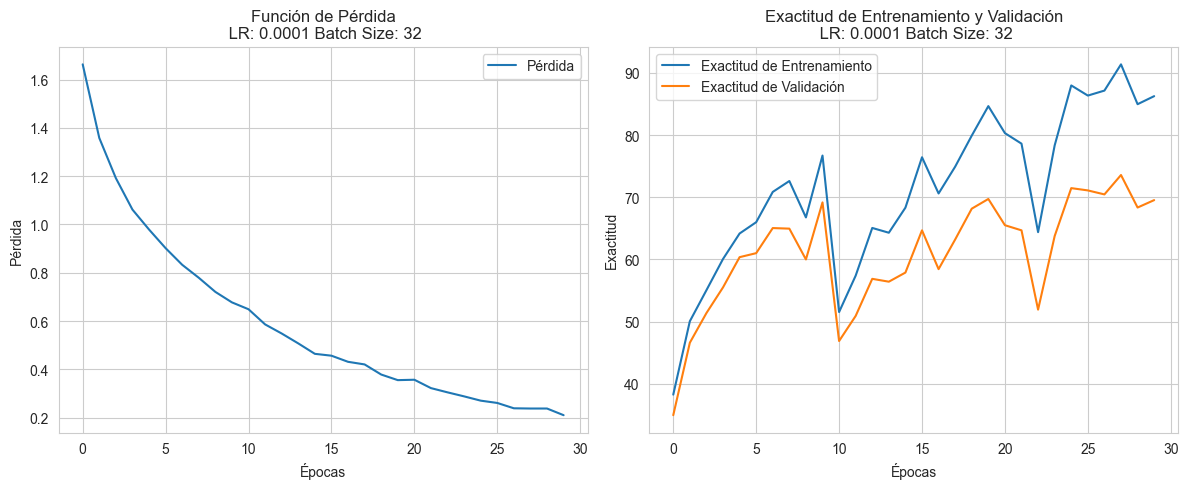


Entrenando con lr=0.0001, batch_size=64, epochs=15
    Época 1, pérdida: 1.7473, exactitud entrenamiento: 15.99%, exactitud validación: 15.60%
    Época 2, pérdida: 1.4760, exactitud entrenamiento: 34.35%, exactitud validación: 33.03%
    Época 3, pérdida: 1.3174, exactitud entrenamiento: 47.13%, exactitud validación: 45.23%
    Época 4, pérdida: 1.1856, exactitud entrenamiento: 53.20%, exactitud validación: 49.72%
    Época 5, pérdida: 1.1030, exactitud entrenamiento: 60.35%, exactitud validación: 55.23%
    Época 6, pérdida: 1.0063, exactitud entrenamiento: 63.68%, exactitud validación: 58.99%
    Época 7, pérdida: 0.9349, exactitud entrenamiento: 63.46%, exactitud validación: 57.61%
    Época 8, pérdida: 0.8723, exactitud entrenamiento: 66.64%, exactitud validación: 61.47%
    Época 9, pérdida: 0.8105, exactitud entrenamiento: 64.85%, exactitud validación: 58.81%
    Época 10, pérdida: 0.7564, exactitud entrenamiento: 65.22%, exactitud validación: 59.54%
    Época 11, pérdida: 0.70

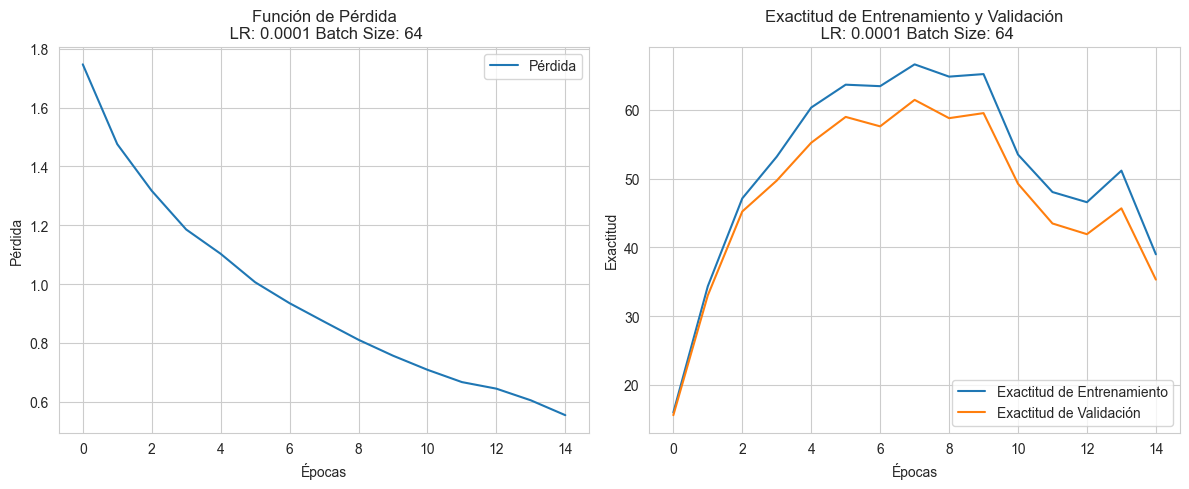


Entrenando con lr=0.0001, batch_size=64, epochs=30
    Época 1, pérdida: 1.6685, exactitud entrenamiento: 21.01%, exactitud validación: 20.55%
    Época 2, pérdida: 1.3886, exactitud entrenamiento: 37.77%, exactitud validación: 36.06%
    Época 3, pérdida: 1.2425, exactitud entrenamiento: 53.05%, exactitud validación: 49.08%
    Época 4, pérdida: 1.1239, exactitud entrenamiento: 63.28%, exactitud validación: 59.27%
    Época 5, pérdida: 1.0025, exactitud entrenamiento: 71.13%, exactitud validación: 66.70%
    Época 6, pérdida: 0.9374, exactitud entrenamiento: 66.76%, exactitud validación: 61.47%
    Época 7, pérdida: 0.8582, exactitud entrenamiento: 72.43%, exactitud validación: 65.50%
    Época 8, pérdida: 0.8003, exactitud entrenamiento: 61.80%, exactitud validación: 58.35%
    Época 9, pérdida: 0.7576, exactitud entrenamiento: 63.56%, exactitud validación: 57.16%
    Época 10, pérdida: 0.7087, exactitud entrenamiento: 66.57%, exactitud validación: 60.92%
    Época 11, pérdida: 0.66

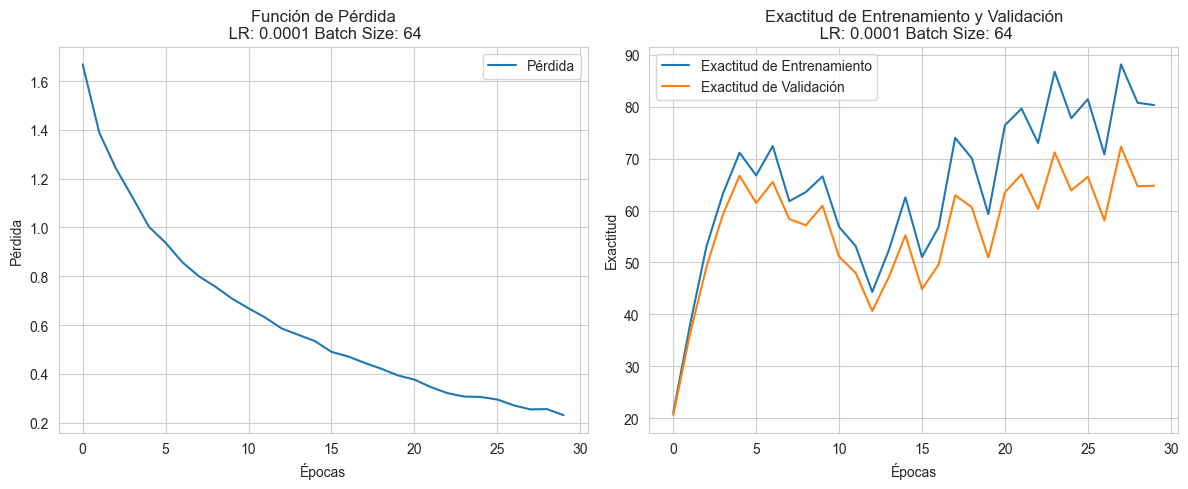


Entrenando con lr=5e-05, batch_size=32, epochs=15
    Época 1, pérdida: 1.7577, exactitud entrenamiento: 22.70%, exactitud validación: 22.29%
    Época 2, pérdida: 1.5033, exactitud entrenamiento: 27.45%, exactitud validación: 26.70%
    Época 3, pérdida: 1.3906, exactitud entrenamiento: 36.29%, exactitud validación: 35.60%
    Época 4, pérdida: 1.3000, exactitud entrenamiento: 40.85%, exactitud validación: 37.89%
    Época 5, pérdida: 1.2145, exactitud entrenamiento: 50.99%, exactitud validación: 45.78%
    Época 6, pérdida: 1.1548, exactitud entrenamiento: 49.41%, exactitud validación: 44.59%
    Época 7, pérdida: 1.0831, exactitud entrenamiento: 50.34%, exactitud validación: 45.87%
    Época 8, pérdida: 1.0431, exactitud entrenamiento: 54.71%, exactitud validación: 48.81%
    Época 9, pérdida: 0.9885, exactitud entrenamiento: 56.32%, exactitud validación: 52.20%
    Época 10, pérdida: 0.9620, exactitud entrenamiento: 52.31%, exactitud validación: 47.80%
    Época 11, pérdida: 0.890

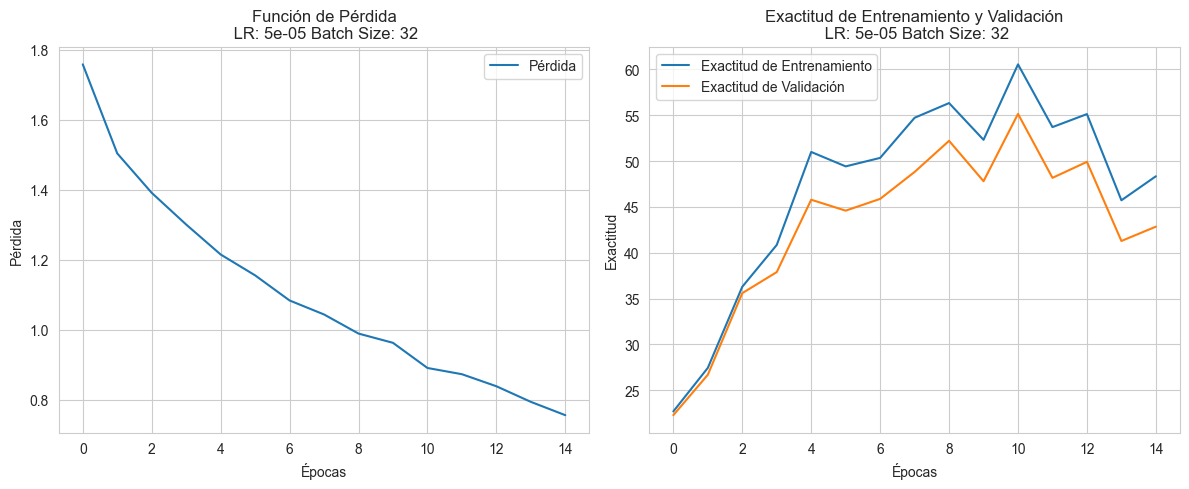


Entrenando con lr=5e-05, batch_size=32, epochs=30
    Época 1, pérdida: 1.7564, exactitud entrenamiento: 30.65%, exactitud validación: 29.45%
    Época 2, pérdida: 1.5027, exactitud entrenamiento: 35.83%, exactitud validación: 33.39%
    Época 3, pérdida: 1.3914, exactitud entrenamiento: 42.54%, exactitud validación: 39.36%
    Época 4, pérdida: 1.2636, exactitud entrenamiento: 48.21%, exactitud validación: 45.23%
    Época 5, pérdida: 1.1901, exactitud entrenamiento: 59.33%, exactitud validación: 55.69%
    Época 6, pérdida: 1.1212, exactitud entrenamiento: 68.05%, exactitud validación: 63.49%
    Época 7, pérdida: 1.0582, exactitud entrenamiento: 67.93%, exactitud validación: 62.11%
    Época 8, pérdida: 1.0002, exactitud entrenamiento: 73.35%, exactitud validación: 67.25%
    Época 9, pérdida: 0.9285, exactitud entrenamiento: 71.29%, exactitud validación: 66.33%
    Época 10, pérdida: 0.8994, exactitud entrenamiento: 72.58%, exactitud validación: 66.61%
    Época 11, pérdida: 0.853

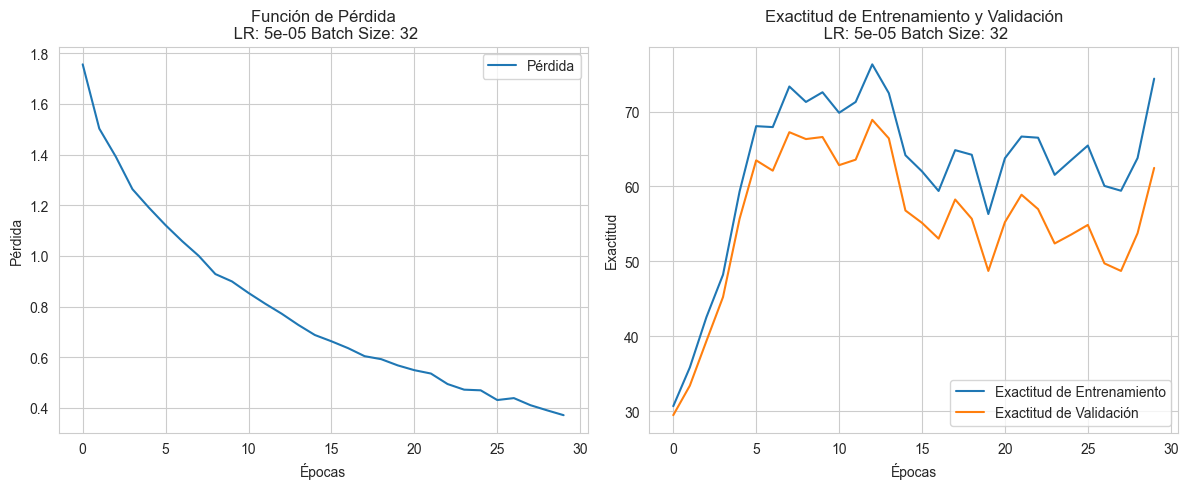


Entrenando con lr=5e-05, batch_size=64, epochs=15
    Época 1, pérdida: 1.8157, exactitud entrenamiento: 15.47%, exactitud validación: 15.05%
    Época 2, pérdida: 1.5916, exactitud entrenamiento: 21.44%, exactitud validación: 20.64%
    Época 3, pérdida: 1.4541, exactitud entrenamiento: 24.31%, exactitud validación: 23.94%
    Época 4, pérdida: 1.3607, exactitud entrenamiento: 29.36%, exactitud validación: 28.72%
    Época 5, pérdida: 1.2933, exactitud entrenamiento: 38.88%, exactitud validación: 36.70%
    Época 6, pérdida: 1.2284, exactitud entrenamiento: 40.42%, exactitud validación: 37.89%
    Época 7, pérdida: 1.1606, exactitud entrenamiento: 44.27%, exactitud validación: 41.19%
    Época 8, pérdida: 1.1119, exactitud entrenamiento: 47.63%, exactitud validación: 43.76%
    Época 9, pérdida: 1.0658, exactitud entrenamiento: 47.35%, exactitud validación: 44.86%
    Época 10, pérdida: 1.0319, exactitud entrenamiento: 51.57%, exactitud validación: 47.52%
    Época 11, pérdida: 0.984

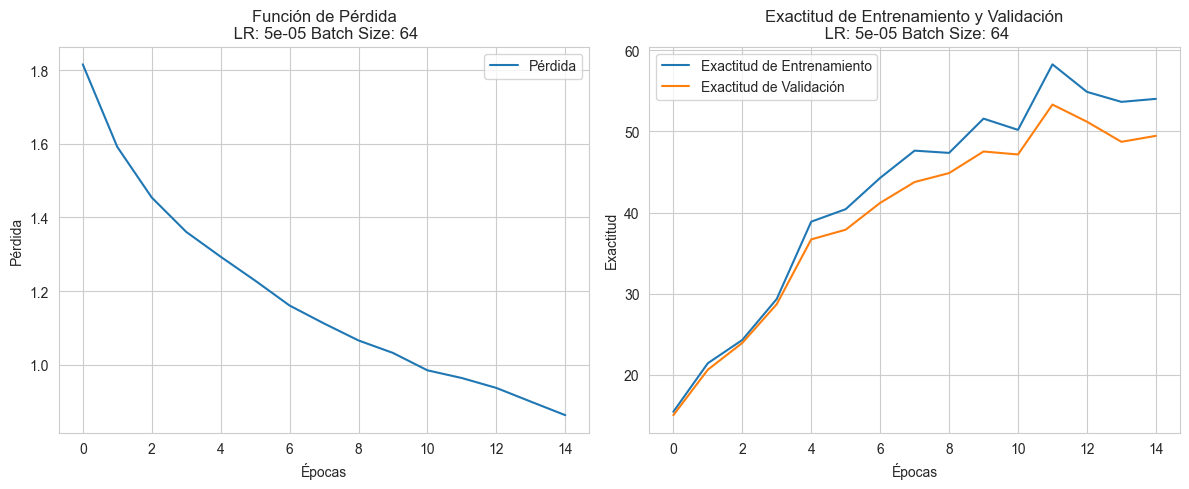


Entrenando con lr=5e-05, batch_size=64, epochs=30
    Época 1, pérdida: 1.7932, exactitud entrenamiento: 17.47%, exactitud validación: 16.61%
    Época 2, pérdida: 1.5558, exactitud entrenamiento: 27.51%, exactitud validación: 25.05%
    Época 3, pérdida: 1.4392, exactitud entrenamiento: 34.04%, exactitud validación: 31.56%
    Época 4, pérdida: 1.3543, exactitud entrenamiento: 40.36%, exactitud validación: 38.90%
    Época 5, pérdida: 1.2768, exactitud entrenamiento: 41.99%, exactitud validación: 38.26%
    Época 6, pérdida: 1.2118, exactitud entrenamiento: 44.30%, exactitud validación: 40.09%
    Época 7, pérdida: 1.1399, exactitud entrenamiento: 50.22%, exactitud validación: 46.15%
    Época 8, pérdida: 1.0928, exactitud entrenamiento: 57.30%, exactitud validación: 51.74%
    Época 9, pérdida: 1.0523, exactitud entrenamiento: 58.78%, exactitud validación: 52.94%
    Época 10, pérdida: 1.0071, exactitud entrenamiento: 62.69%, exactitud validación: 56.79%
    Época 11, pérdida: 0.965

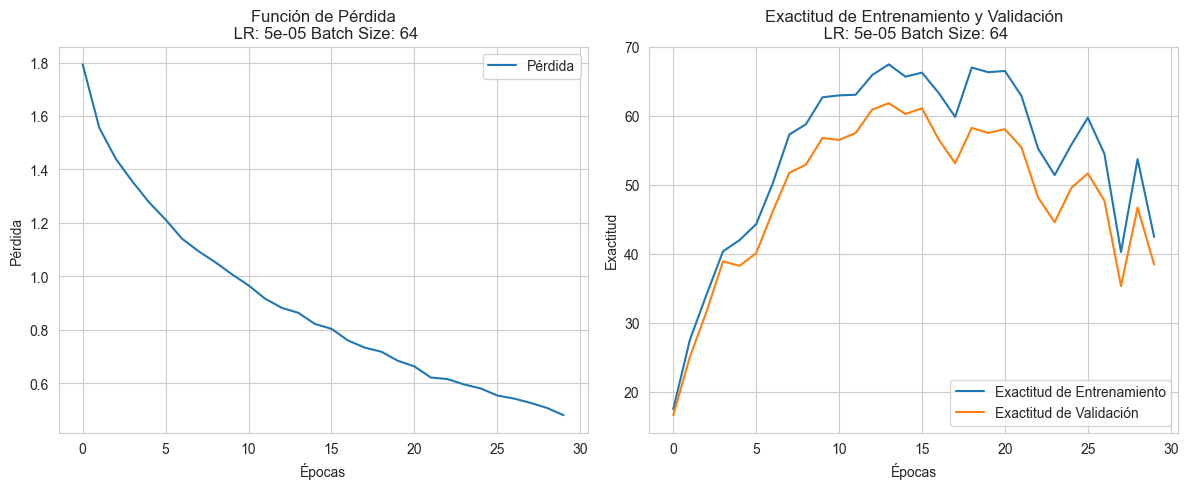


Entrenando con lr=1e-05, batch_size=32, epochs=15
    Época 1, pérdida: 1.9555, exactitud entrenamiento: 16.85%, exactitud validación: 16.15%
    Época 2, pérdida: 1.7865, exactitud entrenamiento: 15.77%, exactitud validación: 15.41%
    Época 3, pérdida: 1.7060, exactitud entrenamiento: 17.78%, exactitud validación: 17.61%
    Época 4, pérdida: 1.6397, exactitud entrenamiento: 19.22%, exactitud validación: 18.81%
    Época 5, pérdida: 1.5843, exactitud entrenamiento: 21.38%, exactitud validación: 21.56%
    Época 6, pérdida: 1.5460, exactitud entrenamiento: 24.65%, exactitud validación: 23.94%
    Época 7, pérdida: 1.5250, exactitud entrenamiento: 25.17%, exactitud validación: 23.94%
    Época 8, pérdida: 1.4757, exactitud entrenamiento: 29.82%, exactitud validación: 27.34%
    Época 9, pérdida: 1.4330, exactitud entrenamiento: 30.90%, exactitud validación: 28.72%
    Época 10, pérdida: 1.4133, exactitud entrenamiento: 34.01%, exactitud validación: 31.74%
    Época 11, pérdida: 1.403

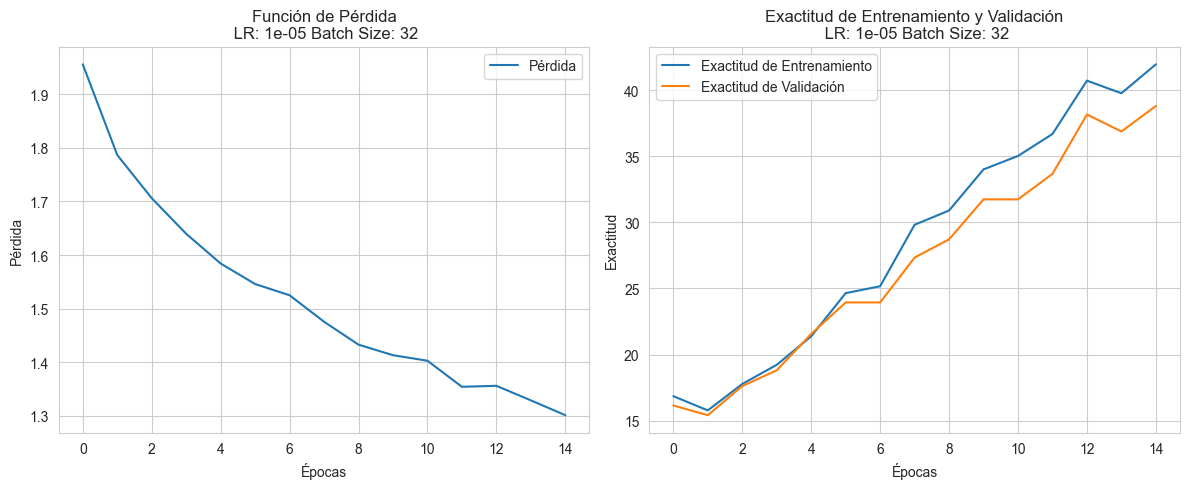


Entrenando con lr=1e-05, batch_size=32, epochs=30
    Época 1, pérdida: 1.9736, exactitud entrenamiento: 16.51%, exactitud validación: 16.33%
    Época 2, pérdida: 1.8074, exactitud entrenamiento: 18.64%, exactitud validación: 18.17%
    Época 3, pérdida: 1.7129, exactitud entrenamiento: 20.67%, exactitud validación: 19.82%
    Época 4, pérdida: 1.6370, exactitud entrenamiento: 21.04%, exactitud validación: 20.09%
    Época 5, pérdida: 1.5881, exactitud entrenamiento: 26.16%, exactitud validación: 24.13%
    Época 6, pérdida: 1.5660, exactitud entrenamiento: 28.19%, exactitud validación: 26.24%
    Época 7, pérdida: 1.5144, exactitud entrenamiento: 32.01%, exactitud validación: 30.46%
    Época 8, pérdida: 1.4766, exactitud entrenamiento: 33.43%, exactitud validación: 31.74%
    Época 9, pérdida: 1.4438, exactitud entrenamiento: 37.99%, exactitud validación: 36.42%
    Época 10, pérdida: 1.4005, exactitud entrenamiento: 38.48%, exactitud validación: 37.06%
    Época 11, pérdida: 1.372

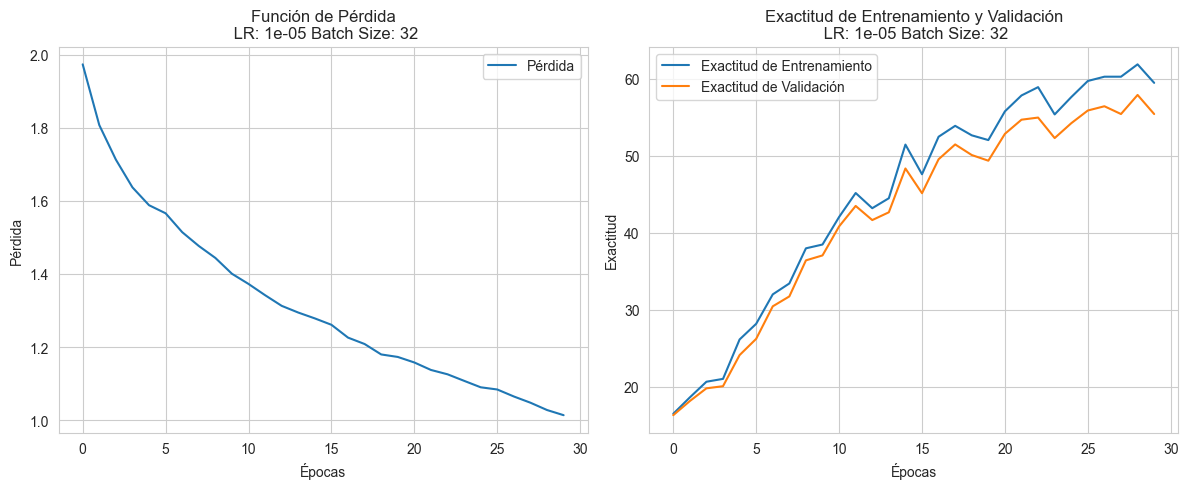


Entrenando con lr=1e-05, batch_size=64, epochs=15
    Época 1, pérdida: 1.9691, exactitud entrenamiento: 17.53%, exactitud validación: 15.78%
    Época 2, pérdida: 1.8387, exactitud entrenamiento: 20.58%, exactitud validación: 19.36%
    Época 3, pérdida: 1.7656, exactitud entrenamiento: 19.65%, exactitud validación: 19.08%
    Época 4, pérdida: 1.6919, exactitud entrenamiento: 17.16%, exactitud validación: 16.24%
    Época 5, pérdida: 1.6486, exactitud entrenamiento: 18.52%, exactitud validación: 17.52%
    Época 6, pérdida: 1.5995, exactitud entrenamiento: 20.09%, exactitud validación: 18.99%
    Época 7, pérdida: 1.5599, exactitud entrenamiento: 22.06%, exactitud validación: 21.38%
    Época 8, pérdida: 1.5367, exactitud entrenamiento: 21.90%, exactitud validación: 20.83%
    Época 9, pérdida: 1.5047, exactitud entrenamiento: 24.61%, exactitud validación: 23.39%
    Época 10, pérdida: 1.4934, exactitud entrenamiento: 27.20%, exactitud validación: 26.15%
    Época 11, pérdida: 1.445

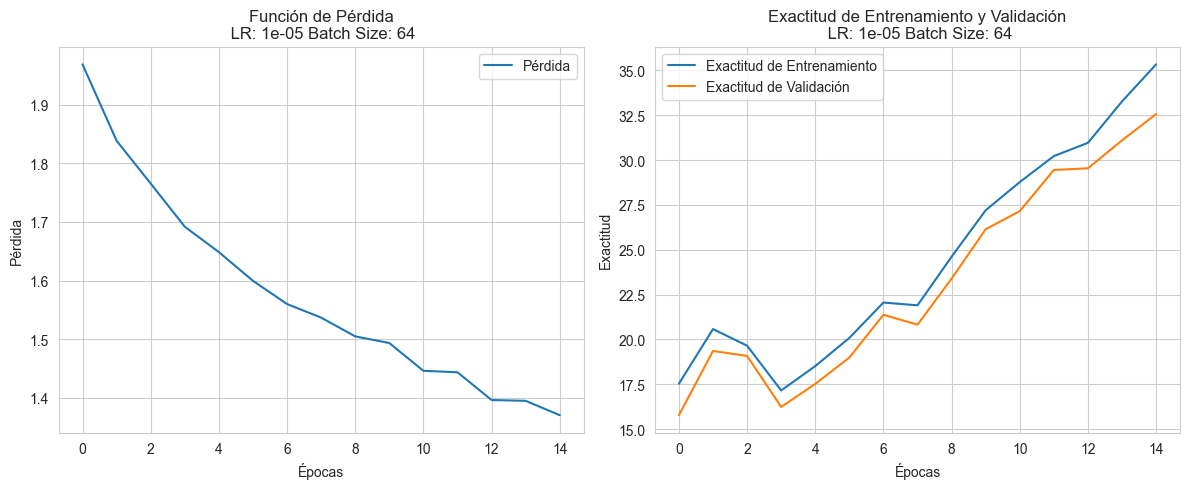


Entrenando con lr=1e-05, batch_size=64, epochs=30
    Época 1, pérdida: 1.9775, exactitud entrenamiento: 14.20%, exactitud validación: 13.94%
    Época 2, pérdida: 1.8157, exactitud entrenamiento: 14.76%, exactitud validación: 14.40%
    Época 3, pérdida: 1.7357, exactitud entrenamiento: 15.16%, exactitud validación: 14.40%
    Época 4, pérdida: 1.7056, exactitud entrenamiento: 15.56%, exactitud validación: 14.68%
    Época 5, pérdida: 1.6338, exactitud entrenamiento: 16.76%, exactitud validación: 16.06%
    Época 6, pérdida: 1.6001, exactitud entrenamiento: 18.82%, exactitud validación: 18.35%
    Época 7, pérdida: 1.5615, exactitud entrenamiento: 20.95%, exactitud validación: 20.55%
    Época 8, pérdida: 1.5343, exactitud entrenamiento: 24.68%, exactitud validación: 23.94%
    Época 9, pérdida: 1.4879, exactitud entrenamiento: 26.37%, exactitud validación: 26.33%
    Época 10, pérdida: 1.4849, exactitud entrenamiento: 27.51%, exactitud validación: 27.80%
    Época 11, pérdida: 1.424

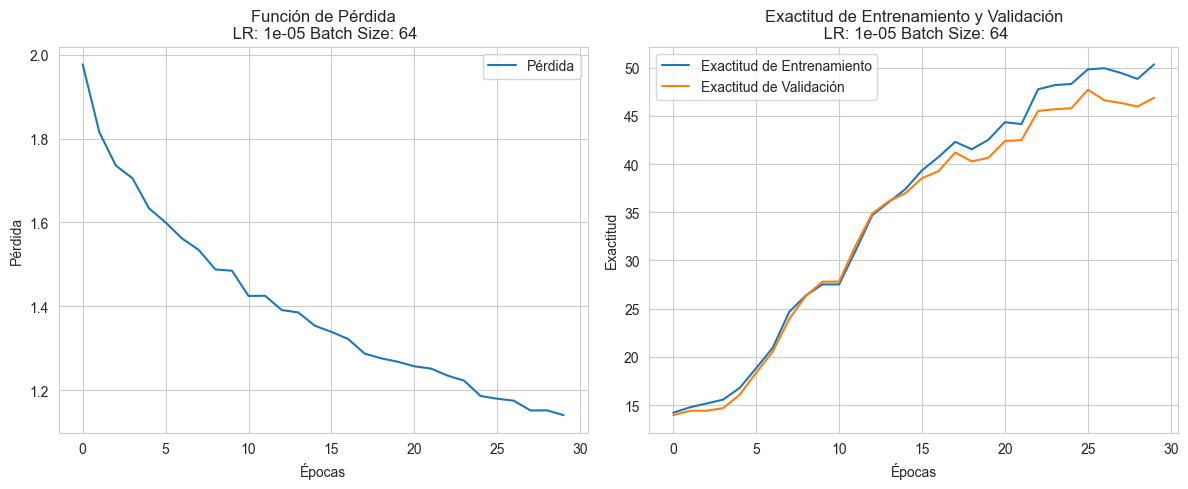

In [19]:
import torch.optim as optim
from itertools import product

learning_rates = [0.005, 0.001, 0.0005, 0.0001, 0.00005, 0.00001]
batch_sizes = [32, 64]
epochs_list = [15, 30]

resultados = []
modelos = {}

for lr, batch_size, epochs in product(learning_rates, batch_sizes, epochs_list):

    # Crear DataLoaders para los datos de entrenamiento, validación y test
    dataloader_entrenamiento = DataLoader(dataset_entrenamiento, batch_size=batch_size, shuffle=True)
    dataloader_validacion = DataLoader(dataset_validacion, batch_size=batch_size, shuffle=False)
    dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    modelo = ConvNet().to(device)
    criterio = nn.CrossEntropyLoss()
    optimizador = optim.Adam(modelo.parameters(), lr=lr)

    combinacion = (lr, batch_size, epochs)
    print(f"\nEntrenando con lr={lr}, batch_size={batch_size}, epochs={epochs}")

    modelos[combinacion] = modelo

    valores_perdida = []
    exactitud_entrenamiento = []
    exactitud_validacion = []

    early_stopping = EarlyStopping(patience=5, delta=0.01)

    for epoca in range(epochs):
        modelos[combinacion].train()
        running_loss = 0.0
        for images, labels in dataloader_entrenamiento:
            images, labels = images.to(device), labels.to(device)
            outputs = modelos[combinacion](images)
            loss = criterio(outputs, labels)
            loss.backward()
            optimizador.step()
            optimizador.zero_grad()
            running_loss += loss.item()

        valores_perdida.append(running_loss / len(dataloader_entrenamiento))

        with torch.no_grad():
            modelos[combinacion].eval()

            # Calcular exactitud de entrenamiento
            correctas = 0
            total = 0
            for images, labels in dataloader_entrenamiento:
                images, labels = images.to(device), labels.to(device)
                outputs = modelos[combinacion](images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correctas += (predicted == labels).sum().item()
            exactitud_entrenamiento.append(100 * correctas / total)

            # Calcular exactitud de validación
            correctas = 0
            total = 0
            for images, labels in dataloader_validacion:
                images, labels = images.to(device), labels.to(device)
                outputs = modelos[combinacion](images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correctas += (predicted == labels).sum().item()
            exactitud_validacion.append(100 * correctas / total)

        # Early stopping
        val_loss = valores_perdida[-1]  # Usamos la pérdida más reciente
        early_stopping(val_loss, modelo)

        # Verifica si se activa la parada anticipada
        if early_stopping.early_stop:
            print("Parada anticipada activada")
            modelo.load_state_dict(early_stopping.best_model_wts)  # Cargar los mejores pesos
            break

        # Imprimir métricas de la época
        print(f'    Época {epoca+1}, pérdida: {val_loss:.4f}, exactitud entrenamiento: {exactitud_entrenamiento[-1]:.2f}%, exactitud validación: {exactitud_validacion[-1]:.2f}%')

    graficar_perdida_entrenamiento_validacion(lr, batch_size, epochs, valores_perdida, exactitud_entrenamiento, exactitud_validacion)
    resultados.append((lr, batch_size, epochs, exactitud_validacion[-1]))




Top configuraciones:
    LR=0.001, Batch=32, Epochs=30, Exactitud validación=86.79%
    LR=0.001, Batch=64, Epochs=30, Exactitud validación=85.50%
    LR=0.001, Batch=32, Epochs=15, Exactitud validación=84.59%
    LR=0.0005, Batch=64, Epochs=30, Exactitud validación=84.59%
    LR=0.0005, Batch=32, Epochs=30, Exactitud validación=83.76%

Exactitud del modelo en el conjunto de test para el conjunto de hiperpárametros LR=0.001, Batch=32, Epochs=30    : 80.71%
Reporte de clasificación:
              precision    recall  f1-score   support

           0     0.7712    0.7919    0.7815       149
           1     0.9444    0.8947    0.9189       152
           2     0.9400    0.6309    0.7550       149
           3     0.7566    0.8266    0.7901       173
           4     0.7811    0.8800    0.8276       150
           5     0.6774    0.7047    0.6908       149
           6     0.8452    0.9103    0.8765       156

    accuracy                         0.8071      1078
   macro avg     0.8166  

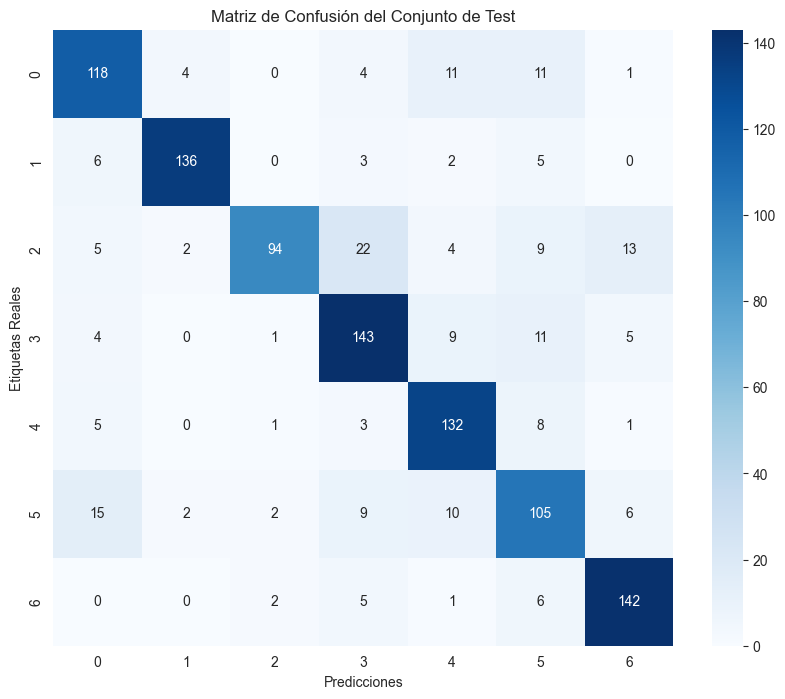

Clases presentes en el conjunto de test: {np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6)}


In [22]:
mejores_resultados = sorted(resultados, key=lambda x: x[3], reverse=True)
print("Top configuraciones:")
for res in mejores_resultados[:5]:
    print(f"    LR={res[0]}, Batch={res[1]}, Epochs={res[2]}, Exactitud validación={res[3]:.2f}%")

mejor = (mejores_resultados[0][0], mejores_resultados[0][1], mejores_resultados[0][2])
modelo = modelos[mejor]
exactitud_test = calcular_exactitud_test(modelo, dataloader_test, device)
print(f"\nExactitud del modelo en el conjunto de test para el conjunto de hiperpárametros LR={mejor[0]}, Batch={mejor[1]}, Epochs={mejor[2]}    : {exactitud_test:.2f}%")
matriz_de_confusion(modelo, dataloader_test, device)